In [3]:
import findspark
findspark.init()
import pyspark

In [4]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200

config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
            .set('spark.cores.max', '10')\
            .set('spark.port.maxRetries','200')\
            .set('spark.ui.port', port)\
            .set('spark.master', 'spark://polyp1:7077')\
            .set('spark.app.name', "structuredComputation")

#sc = pyspark.SparkContext(conf = config)
ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()

# print ss.conf.get('spark.app.name')
# print ss.conf.get('spark.master')

In [5]:
# Input data
sc = ss.sparkContext
GreenTaxi = sc.textFile("/scratch/ISE495/taxi_data")

In [6]:
for i in GreenTaxi.take(5):
    print i,"\n"

VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type 

2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979484558105469,40.684955596923828,-73.97943115234375,40.685020446777344,1,.00,7.8,0,0,1.95,0,,0,9.75,1,2 

2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010795593261719,40.912216186523438,-74.010780334472656,40.912212371826172,1,.00,45,0,0,0,0,,0,45,1,2 

2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921409606933594,40.766708374023438,-73.914413452148438,40.764686584472656,1,.59,4,0.5,0.5,0.5,0,,0.3,5.8,1,1 

2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.92138671875,40.766677856445313,-73.931427001953125,40.771583557128906,1,.74,5,0.5,0.5,0,0,,0.3,6.3,2,1 



In [7]:
# Creating function to get 'header' of the dataset along with 'index' for each header for future reference in data analysis
def headsep(s):
    i = 0
    f = []
    for i in range(len(s)):
        f.append([s[i],i])
    return f
        

In [8]:
# [Header, Index] view
head = GreenTaxi.filter(lambda x: x[0:2] == 'Ve').map(lambda x:x.split(",")).map(headsep)
print head.collect()

[[[u'VendorID', 0], [u'lpep_pickup_datetime', 1], [u'Lpep_dropoff_datetime', 2], [u'Store_and_fwd_flag', 3], [u'RateCodeID', 4], [u'Pickup_longitude', 5], [u'Pickup_latitude', 6], [u'Dropoff_longitude', 7], [u'Dropoff_latitude', 8], [u'Passenger_count', 9], [u'Trip_distance', 10], [u'Fare_amount', 11], [u'Extra', 12], [u'MTA_tax', 13], [u'Tip_amount', 14], [u'Tolls_amount', 15], [u'Ehail_fee', 16], [u'improvement_surcharge', 17], [u'Total_amount', 18], [u'Payment_type', 19], [u'Trip_type', 20]]]


In [9]:
#Task 1: Green Taxi Data Analysis using Map & Reduce functions 

#Task 1.1: Creating 4 Trip Categories - New york to New york (nyny);New Jersey to New Jersey (njnj); New york to New Jersey (nynj); New Jersey to New york (njny)

rDD = GreenTaxi.filter(lambda x: x[0:2] != 'Ve').map(lambda x:x.split(","))
print 'Total Trips:',rDD.count()
nyny = rDD.filter(lambda y: (float(y[6])<(1.323942*float(y[5]) + 138.669195)) &(float(y[8])<(1.323942*float(y[7]) + 138.669195)))
nynyTrips = nyny.count()
print 'Trips from New York to New York:',nynyTrips
njnj = rDD.filter(lambda y: (float(y[6])>(1.323942*float(y[5]) + 138.669195)) &(float(y[8])>(1.323942*float(y[7]) + 138.669195)))
njnjTrips = njnj.count()
print 'Trips from New Jersey to New Jersey:',njnjTrips
nynj = rDD.filter(lambda y: (float(y[6])<(1.323942*float(y[5]) + 138.669195)) &(float(y[8])>(1.323942*float(y[7]) + 138.669195)))
nynjTrips = nynj.count()
print 'Trips from New York to New Jersey:',nynjTrips
njny = rDD.filter(lambda y: (float(y[6])>(1.323942*float(y[5]) + 138.669195)) &(float(y[8])<(1.323942*float(y[7]) + 138.669195)))
njnyTrips = njny.count()
print 'Trips from New Jersey to New York:',njnyTrips
print 'verify:',nyny.count() + njnj.count() + njny.count() + nynj.count()

Total Trips: 1495926
Trips from New York to New York: 865242
Trips from New Jersey to New Jersey: 449317
Trips from New York to New Jersey: 144218
Trips from New Jersey to New York: 37149
verify: 1495926


In [12]:
# for plot
tripsarr = [nynyTrips,njnjTrips,nynjTrips,njnyTrips]
tripsarrnames = ["nynyTrips","njnjTrips","nynjTrips","njnyTrips"]

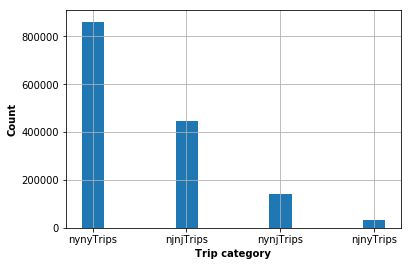

In [15]:
# Histogram of Trip Categories
import numpy as np
from  matplotlib import pyplot as plt
r1 = np.arange(len(tripsarr))
plt.grid(True)
plt.bar(r1, tripsarr, width=0.25, edgecolor='white', label='comp1')
plt.xlabel('Trip category', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r for r in range(len(tripsarrnames))], tripsarrnames)
plt.show()


In [19]:

#create the 4 pair buckets
def statescategories(taxi):
    RDD=taxi.split(",")
    

    plon= float(RDD[5])
    plat= float(RDD[6])
    dlon= float(RDD[7])
    dlat= float(RDD[8])
        
    if plat>1.323942*plon+138.669195:
        pickup_location="NJ"
    else:
         pickup_location="NY"
       
    if dlat>1.323942*dlon+138.669195:
        dropoff_location="NJ"
    else:
        dropoff_location="NY"
       
        
    return pickup_location, dropoff_location



In [ ]:
pairedRDD=GreenTaxi.map(statescategories)
print pairedRDD.take(5)
print pairedRDD.count()

In [ ]:
parsedData=pairedRDD.map(lambda x:(x,1)).reduceByKey(lambda a,b:a+b).collect()

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(parsedData)):
    X.append(str(parsedData[i][0]))
for i in range(len(parsedData)):
    Y.append(parsedData[i][1])
print X, Y
print type(Y[1])

In [ ]:
from  matplotlib import pyplot as plt
plt.xlabel("Pickup time")
plt.ylabel("Trip Count")
plt.grid(True)
plt.bar(X,Y)
plt.show()

In [ ]:
#Inference: Maximum number of trips are intra -Borough (NY-NY) and (NJ-NJ)
#A)Inferencing NY-NY transit data

In [ ]:
#Trip Count VS Pickup Time
#Convert the Time-stamp
from datetime import datetime
def timestamp(time):
    
    RDD=time.split(",")
    date=RDD[1].split(" ")
    RDD.insert(len(RDD),datetime.strptime(date[0], '%Y-%m-%d').date())
    RDD.insert(len(RDD),datetime.strptime(date[1], '%H:%M:%S').strftime("%H"))
    RDD.remove((RDD)[1])
    
    date=RDD[1].split(" ")
    RDD.insert(len(RDD),datetime.strptime(date[0], '%Y-%m-%d').date())
    RDD.insert(len(RDD),datetime.strptime(date[1], '%H:%M:%S').strftime("%H"))#Extracting only hours
    RDD.remove((RDD)[1])
    
    return RDD

In [ ]:
pairedRDD1=taxi.map(timestamp)
print pairedRDD1.take(1)
print pairedRDD1.take(1)[0][-1]

In [ ]:
def dict(line):
    dict=[]
    dict.append([line[-3],1])
    return dict

RDD2=pairedRDD1.flatMap(dict).reduceByKey(lambda a,b: a+b)

#print RDD2.collect()
RDD3=RDD2.collect()
print RDD3

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(RDD3)):
    X.append(str(RDD3[i][0]))
for i in range(len(RDD3)):
    Y.append(RDD3[i][1])
    X=sorted(X)
    Y=sorted(Y)
print X, Y
print type(Y[1])

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(RDD3)):
    X.append(str(RDD3[i][0]))
for i in range(len(RDD3)):
    Y.append(RDD3[i][1])
    X=sorted(X)
    Y=sorted(Y)
print X, Y
print type(Y[1])

In [ ]:
from  matplotlib import pyplot as plt
plt.xlabel("Pickup_Hours")
plt.ylabel("Ride_Count")
plt.grid(True)
plt.bar(X,Y)
plt.show()

In [ ]:
#NY-NY: Pickup Hrs vs Total Trip

In [ ]:
rDD = taxi.filter(lambda x: x[0:2] != 'Ve').map(lambda x:x.split(","))
nyny1 = rDD.filter(lambda y: (float(y[6])<(1.323942*float(y[5]) + 138.669195)) &(float(y[8])<(1.323942*float(y[7]) + 138.669195)))\
        .map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),\
        y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),\
        (datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H"))])


In [ ]:
print nyny1.take(1)

In [ ]:
def dict1(line):
    dict1=[]
    dict1.append([line[-1],1])
    return dict1

RDD4=nyny1.flatMap(dict1).reduceByKey(lambda a,b: a+b)

#print RDD2.collect()
RDD5=RDD4.collect()
print RDD5

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(RDD5)):
    X.append(str(RDD5[i][0]))
for i in range(len(RDD5)):
    Y.append(RDD5[i][1])
    X=sorted(X)
    Y=sorted(Y)
print X, Y

In [ ]:
from  matplotlib import pyplot as plt
plt.xlabel("Pickup_Hours")
plt.ylabel("Ride_Count")
plt.title("NY-NY Transit")
plt.grid(True)
plt.bar(X,Y)
plt.show()

In [ ]:
#NJ-NJ transit 
njnj1 = rDD.filter(lambda y: (float(y[6])>(1.323942*float(y[5]) + 138.669195)) &(float(y[8])>(1.323942*float(y[7]) + 138.669195)))\
        .map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),\
                        y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],\
                        (datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H"))])

In [ ]:
print njnj1.take(1)

In [ ]:
def dict2(line):
    dict2=[]
    dict2.append([line[-1],1])
    return dict2

RDD6=njnj1.flatMap(dict2).reduceByKey(lambda a,b: a+b)

#print RDD2.collect()
RDD7=RDD6.collect()
print RDD7

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(RDD7)):
    X.append(str(RDD7[i][0]))
for i in range(len(RDD7)):
    Y.append(RDD7[i][1])
    X=sorted(X)
    Y=sorted(Y)
print X, Y


In [ ]:
from  matplotlib import pyplot as plt
plt.xlabel("Pickup_Hours")
plt.ylabel("Ride_Count")
plt.title("NJ-NJ Transit")
plt.grid(True)
plt.bar(X,Y)
plt.show()

In [ ]:
#NY-NJ transit 
nynj1 = rDD.filter(lambda y: (float(y[6])<(1.323942*float(y[5]) + 138.669195)) &(float(y[8])>(1.323942*float(y[7]) + 138.669195))).map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H"))])
print nynj1.count()

In [ ]:
def dict3(line):
    dict3=[]
    dict3.append([line[-1],1])
    return dict3

RDD8=nynj1.flatMap(dict3).reduceByKey(lambda a,b: a+b)

#print RDD2.collect()
RDD9=RDD8.collect()
print RDD9

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(RDD9)):
    X.append(str(RDD9[i][0]))
for i in range(len(RDD9)):
    Y.append(RDD9[i][1])
    X=sorted(X)
    Y=sorted(Y)
print X, Y

In [ ]:
from  matplotlib import pyplot as plt
plt.xlabel("Pickup_Hours")
plt.ylabel("Ride_Count")
plt.title("NY-NJ Transit")
plt.grid(True)
plt.bar(X,Y)
plt.show()

In [ ]:
#NJ-NY transit 
njny1 = rDD.filter(lambda y: (float(y[6])>(1.323942*float(y[5]) + 138.669195)) &(float(y[8])<(1.323942*float(y[7]) + 138.669195))).map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H"))])

In [ ]:
print njny1.count()

In [ ]:
def dict4(line):
    dict4=[]
    dict4.append([line[-1],1])
    return dict4

RDD10=njny1.flatMap(dict4).reduceByKey(lambda a,b: a+b)

#print RDD2.collect()
RDD11=RDD10.collect()
print RDD11

In [ ]:
#Graph Co ordinates

X=[]
Y=[]
for i in range(len(RDD11)):
    X.append(str(RDD11[i][0]))
for i in range(len(RDD11)):
    Y.append(RDD11[i][1])
    X=sorted(X)
    Y=sorted(Y)
print X, Y

In [ ]:
from  matplotlib import pyplot as plt
plt.xlabel("Pickup_Hours")
plt.ylabel("Ride_Count")
plt.title("NJ-NY Transit")
plt.grid(True)
plt.bar(X,Y)
plt.show()

Text(0,0.5,'Frequency')

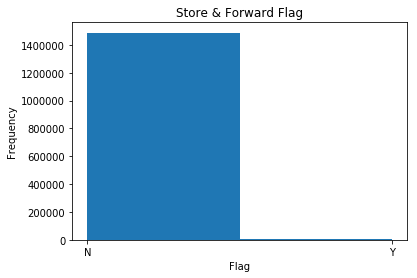

In [160]:
#Histogram of Store_and_fwd_Flag
import matplotlib.pyplot as plt

strfwd = rDD.map(lambda x:x[3]).collect()

plt.hist(strfwd, bins = 2)
plt.title('Store & Forward Flag')
plt.xlabel('Flag')
plt.axis('auto')
plt.ylabel('Frequency')

In [13]:
#[total trips]
strfwd1 = rDD.map(lambda x:(x[3],1)).reduceByKey(lambda a,b: a+b)
print strfwd1.collect()

[(u'N', 1487192), (u'Y', 8734)]


In [14]:
strfwdnyny = nyny.map(lambda x:(x[3],1)).reduceByKey(lambda a,b: a+b)
print strfwdnyny.collect()

[(u'N', 860427), (u'Y', 4815)]


In [15]:
strfwdnjnj = njnj.map(lambda x:(x[3],1)).reduceByKey(lambda a,b: a+b)
print strfwdnjnj.collect()

[(u'N', 446547), (u'Y', 2770)]


In [16]:
strfwdnjny = njny.map(lambda x:(x[3],1)).reduceByKey(lambda a,b: a+b)
print strfwdnjny.collect()

[(u'N', 36770), (u'Y', 379)]


In [17]:
strfwdnynj = nynj.map(lambda x:(x[3],1)).reduceByKey(lambda a,b: a+b)
print strfwdnynj.collect()

[(u'N', 143448), (u'Y', 770)]


In [163]:
# Task 1.2: Avg tip amount for different trip categories
total_trips = rDD.count()
print 'Total Trips Count:',total_trips
sumOfTips_AllTrip = rDD.map(lambda z:float(z[14])).reduce(lambda a,b: a+b)
print 'Sum of Tip amount of all trips:',sumOfTips_AllTrip
print 'Average tip amount for total_trips:',(sumOfTips_AllTrip/total_trips)
sumOfTips_nyny = nyny.map(lambda z:float(z[14])).reduce(lambda a,b: a+b)
sumOfTips_njnj = njnj.map(lambda z:float(z[14])).reduce(lambda a,b: a+b)
sumOfTips_njny = njny.map(lambda z:float(z[14])).reduce(lambda a,b: a+b)
sumOfTips_nynj = nynj.map(lambda z:float(z[14])).reduce(lambda a,b: a+b)
print 'Average tip amount by trip Category:\n nyny =',(sumOfTips_nyny/nynyTrips),'\n njnj =',(sumOfTips_njnj/njnjTrips),'\n njny =',(sumOfTips_njny/njnyTrips),'\n nynj =',(sumOfTips_nynj/nynjTrips)

Total Trips Count: 1495926
Sum of Tip amount of all trips: 1848358.56
Average tip amount for total_trips: 1.23559491579
Average tip amount by trip Category:
 nyny = 1.08615938662 
 njnj = 0.932354506952 
 njny = 2.38792618913 
 nynj = 2.78006933947


In [164]:
#Inference for Task 1.2: Average Tip Amount is high for InterState Trips(nyny,njnj) as compared to IntraState Trips(nynj,njny)

In [169]:
# Task 1.3: Average Fare Amount by RateCodeID
avgFareByRateCodeId = rDD.map(lambda y: (y[4],float(y[11])))
print avgFareByRateCodeId.take(1)

[(u'5', 7.8)]


In [170]:
# find avg fare amount grouped by rate code id:
import operator
countsByKey = sc.broadcast(avgFareByRateCodeId.countByKey()) 
avgFareByRateCodeId = avgFareByRateCodeId.reduceByKey(operator.add) 
avgFareByRateCodeId = avgFareByRateCodeId.map(lambda x: (x[0], x[1]/countsByKey.value[x[0]])) 
print'Avg Fare Amount grouped by Rate Code Id:',(avgFareByRateCodeId.collect())

Avg Fare Amount grouped by Rate Code Id: [(u'2', 49.001126379815275), (u'4', 60.11719222462204), (u'6', 2.138888888888889), (u'1', 12.244551272229577), (u'3', 48.79856759176365), (u'5', 18.085052259679088), (u'99', 12.183333333333332)]


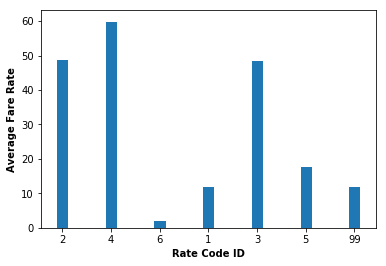

In [171]:
# Bar Plot for Average Fare Amount by Rate Code ID
import numpy as np
names = avgFareByRateCodeId.keys().collect()
values = avgFareByRateCodeId.values().collect()
r1 = np.arange(len(names))

plt.bar(r1, values, width=0.25, edgecolor='white', label='comp1')
plt.xlabel('Rate Code ID', fontweight='bold')
plt.ylabel('Average Fare Rate', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()


In [172]:
#Inference for Task 1.3: Average Fare Amount for RateCode ID 2(JFK),3(Newark),4(Nassau or Westchester) is way more then other RateCode ID consisting of Standard rate, Negotiated fare, Group Ride.

In [180]:
# Task 1.4: Airport Statistics (RateCodeId : 2(JFK Airport), 3(EWR Airport))
     # Task 1.4.1: Number of rides per airport
     # Task 1.4.2: Footfall - jfk & newark - (number of passengers)
     # Task 1.4.3: Footfall - jfk & newark -  (Avg passenger count)
    # Task 1.4.4:  jfk & newark -  'passenger count' frequency by airport (trip counts for no. of passengers (eg. 1 passenger rides, 2 passenger rides)

In [181]:
# Task 1.4.1: Number of rides per airport
airport = rDD.filter(lambda x: x[4]=='2'or x[4]=='3')
RideAirport = airport.count()
print 'Rides to Airport:',RideAirport
jfk = rDD.filter(lambda x: x[4]=='2')
RideJfk = jfk.count()
print 'Rides to JFK:',RideJfk
newark = rDD.filter(lambda x: x[4]=='3')
RideNewark = newark.count()
print 'Rides to newark:',RideNewark

Rides to Airport: 5556
Rides to JFK: 4439
Rides to newark: 1117


In [182]:
# Task 1.4.2: Footfall - jfk & newark - (number of passengers)
countPassengerAirport = airport.map(lambda x: int(x[9])).reduce(lambda a,b: a+b)
print 'Total Passengers travelled to Airport:',countPassengerAirport
countPassengerJFK = jfk.map(lambda x: int(x[9])).reduce(lambda a,b: a+b)
print 'Passengers travelled to JFK:',countPassengerJFK
countPassengerNewark = newark.map(lambda x: int(x[9])).reduce(lambda a,b: a+b)
print 'Passengers travelled to Newark:',countPassengerNewark

Total Passengers travelled to Airport: 7503
Passengers travelled to JFK: 5943
Passengers travelled to Newark: 1560


In [183]:
 # Task 1.4.3: Footfall - jfk & newark -  (Avg passenger count)
AvgPassengerAirport = (countPassengerAirport*1.0)/(RideAirport)
print 'Average No. of Passengers travelled to Airport:',AvgPassengerAirport
AvgPassengerJFK = (countPassengerJFK*1.0)/(RideJfk)
print 'Average No. of Passengers travelled to JFK Airport:',AvgPassengerJFK
AvgPassengerNewark = (countPassengerNewark*1.0)/(RideNewark)
print 'Average No. of Passengers travelled to Newark(EWR):',AvgPassengerNewark


Average No. of Passengers travelled to Airport: 1.35043196544
Average No. of Passengers travelled to JFK Airport: 1.33881504843
Average No. of Passengers travelled to Newark(EWR): 1.39659803044


In [184]:
 # Task 1.4.4:  jfk & newark -  'passenger count' frequency by airport (trip counts for no. of passengers (eg. 1 passenger rides, 2 passenger rides))
countPassengerJFK1 = dict(jfk.map(lambda x: x[9]).countByValue())
print 'Trip Counts by Number of Passengers by JFK Airport',countPassengerJFK1
countPassengerNewark1 = dict(newark.map(lambda x: x[9]).countByValue())
print 'Trip Counts by Number of Passengers by EWR Airport',countPassengerNewark1

Trip Counts by Number of Passengers by JFK Airport {u'1': 3692, u'0': 1, u'3': 78, u'2': 452, u'5': 145, u'4': 19, u'6': 52}
Trip Counts by Number of Passengers by EWR Airport {u'1': 902, u'0': 3, u'3': 26, u'2': 119, u'5': 50, u'4': 5, u'6': 12}


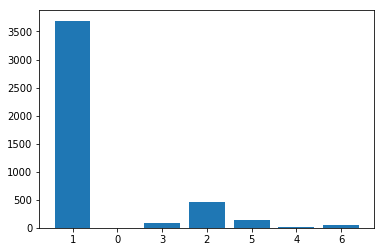

In [185]:
# Histogram of Trip Counts by Number of Passengers by JFK Airport
plt.bar(range(len(countPassengerJFK1)), countPassengerJFK1.values(), align='center')
plt.xticks(range(len(countPassengerJFK1)), list(countPassengerJFK1.keys()))

plt.show()


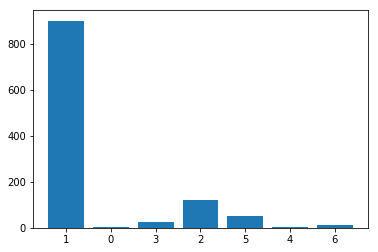

In [186]:
# Histogram of Trip Counts by Number of Passengers by EWR Airport
plt.bar(range(len(countPassengerNewark1)), countPassengerNewark1.values(), align='center')
plt.xticks(range(len(countPassengerNewark1)), list(countPassengerNewark1.keys()))

plt.show()


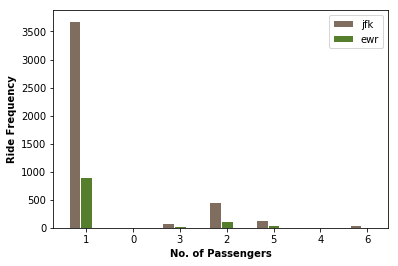

In [198]:
# Histogram Of Comparison for Trip Counts by Number of Passengers by both Airport

jfk = countPassengerJFK1.keys()
comp1Val = countPassengerJFK1.values()
ewr = countPassengerNewark1.keys()
comp2Val = countPassengerNewark1.values()
r1 = np.arange(len(jfk))
r2 = [x + 0.25 for x in r1]

plt.bar(r1, comp1Val, color='#7f6d5f', width=0.25, edgecolor='white', label='jfk')
plt.bar(r2, comp2Val, color='#557f2d', width=0.25, edgecolor='white', label='ewr')
plt.ylabel('Ride Frequency', fontweight='bold')
plt.xlabel('No. of Passengers', fontweight='bold')
plt.xticks([r + 0.25 for r in range(len(jfk))], jfk)

plt.legend()
plt.show()


In [189]:
#Inference for Task 1.4: 
  #1.Help green nyc taxi service to gain insights whethr to opt for pooled cabs at the specific time per days
  #2. From No. of Trips statistics as well as No. of Passenger Count Statistics, We can conclude that JFK Airport is more busy compared to EWR(Newark) Airport

In [190]:
# Task 1.5: Mean Distance traveled in the hour of the day

In [191]:
#Convert the Time-stamp
from datetime import datetime
def timestamp(time):
   
    
    date=time[1].split(" ")
    time.insert(len(time),datetime.strptime(date[0], '%Y-%m-%d').date())
    time.insert(len(time),datetime.strptime(date[1], '%H:%M:%S').strftime("%H"))
    time.remove((time)[1])
   
    date=time[1].split(" ")
    time.insert(len(time),datetime.strptime(date[0], '%Y-%m-%d').date())
    time.insert(len(time),datetime.strptime(date[1], '%H:%M:%S').strftime("%H"))#Extracting only hours
    time.remove((time)[1])
   
    return time

In [192]:
pairedRDD1=rDD.map(timestamp)
print pairedRDD1.take(1)
print pairedRDD1.take(1)[0][-1]

[[u'2', u'N', u'5', u'-73.979484558105469', u'40.684955596923828', u'-73.97943115234375', u'40.685020446777344', u'1', u'.00', u'7.8', u'0', u'0', u'1.95', u'0', u'', u'0', u'9.75', u'1', u'2', datetime.date(2015, 9, 1), '00', datetime.date(2015, 9, 1), '00']]
00


In [193]:
# hour of day: no of trips

In [194]:
# mean distance by hour of day 
tripInHr = pairedRDD1.map(lambda x:(x[20],float(x[8])))


In [195]:
print tripInHr.take(1)

[('00', 0.0)]


In [196]:
countsKey = sc.broadcast(tripInHr.countByKey()) 
tripInHr = tripInHr.reduceByKey(operator.add)
tripInHr = tripInHr.map(lambda x: (x[0], x[1]/countsKey.value[x[0]]))
tripInHr1 = tripInHr.sortByKey().collect()
print 'Mean Distance by hour of day:',tripInHr1

Mean Distance by hour of day: [('00', 3.1154128642272356), ('01', 3.0173471816710977), ('02', 3.0461755995727717), ('03', 3.21294532237674), ('04', 3.5265550257341807), ('05', 4.133474251497005), ('06', 4.055148894869198), ('07', 3.284394444709132), ('08', 3.0484495887390874), ('09', 2.9991052283682906), ('10', 2.9444823205958093), ('11', 2.9120154601961583), ('12', 2.9030647783080843), ('13', 2.8782944482140675), ('14', 2.8643042721708944), ('15', 2.857039998915654), ('16', 2.779851560822164), ('17', 2.6791138578991593), ('18', 2.6532220679726484), ('19', 2.7155968837436655), ('20', 2.7770517155917838), ('21', 2.999188611441709), ('22', 3.1853935422938484), ('23', 3.1915379409737445)]


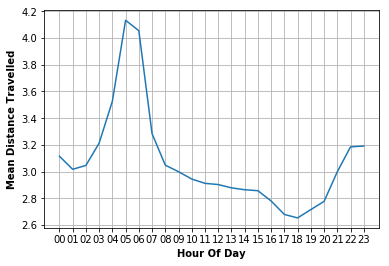

In [197]:
# Line Graph of Mean Distance Travelled by Hour of Day
import numpy as np
names = sorted(tripInHr.keys().collect())
values = tripInHr.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hour Of Day', fontweight='bold')
plt.ylabel('Mean Distance Travelled', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [199]:
#Inference for Task 1.5:
    # Mean Distance Travelld is maximum during 5th hour of the day (i.e. 5am in the morning) and in general it is considerably high between 3am to 7am.

In [200]:
# Task 1.6: ny to ny trips: count of uptown to downtown & downtown to uptown trips

In [202]:
nynycnt = nyny.collect()
uptown_to_downtown = 0
downtown_to_uptown = 0
for i in nynycnt:
    if i[6]> i[8]:
        downtown_to_uptown+=1
    else:
        uptown_to_downtown+=1
print 'Trips from Downtown to Uptown:',downtown_to_uptown
print 'Trips from Uptown to Downtown:',uptown_to_downtown
print 'Total Ny to Ny Trips:',nyny.count()
print 'verify:',downtown_to_uptown+uptown_to_downtown
   
    

Trips from Downtown to Uptown: 466550
Trips from Uptown to Downtown: 398692
Total Ny to Ny Trips: 865242
verify: 865242


In [45]:
#Task 1.7: total distance travelled in days of september: all trips and all bucket trips
    #inference: Total distance travelled is minimal on Mondays, Tuesdays of all weeks in the month of september (all trips as well as individual buckets)

In [206]:
dateRDD1 = rDD.map(lambda x: (x[1].split(" "),x[10])).map(lambda y: (y[0][0].split("-")[2],float(y[1]))).reduceByKey(lambda a,b: a+b)
print 'total distance travelled in days of september (all trips):',dateRDD1.sortByKey().collect()

total distance travelled in days of september (all trips): [(u'01', 122513.24999999993), (u'02', 128236.22999999965), (u'03', 140418.9299999988), (u'04', 162975.13000000006), (u'05', 186512.51000000018), (u'06', 168985.69999999864), (u'07', 134456.8799999998), (u'08', 124812.82999999952), (u'09', 134650.96999999994), (u'10', 144659.98999999947), (u'11', 165757.7800000004), (u'12', 205720.95000000234), (u'13', 175904.92999999988), (u'14', 116218.49999999999), (u'15', 117496.27999999956), (u'16', 134455.64999999924), (u'17', 142427.31999999986), (u'18', 166443.4400000004), (u'19', 213864.6999999988), (u'20', 182536.83999999915), (u'21', 124354.28000000044), (u'22', 114081.68000000092), (u'23', 118218.85999999953), (u'24', 116158.59999999996), (u'25', 152454.59000000055), (u'26', 200601.51999999987), (u'27', 174211.140000002), (u'28', 120490.66000000031), (u'29', 121887.67000000094), (u'30', 128767.71999999991)]


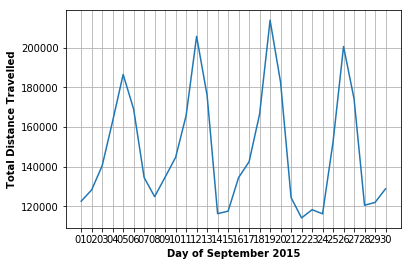

In [207]:
#total distance travelled in days of september (all trips)
names = sorted(dateRDD1.keys().collect())
values = dateRDD1.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Day of September 2015', fontweight='bold')
plt.ylabel('Total Distance Travelled', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [48]:
#inference: Total distance travelled is minimal on Mondays, Tuesdays of all weeks in the month of september (all trips)

In [208]:
dateRDD2 = nyny.map(lambda x: (x[1].split(" "),x[10])).map(lambda y: (y[0][0].split("-")[2],float(y[1]))).reduceByKey(lambda a,b: a+b)
print 'total distance travelled in days of september (nyny trips)',dateRDD2.sortByKey().collect()

total distance travelled in days of september (nyny trips) [(u'01', 59384.189999999915), (u'02', 63134.670000000006), (u'03', 71627.36000000018), (u'04', 84454.46000000027), (u'05', 99688.09999999973), (u'06', 92341.45000000093), (u'07', 74581.44999999946), (u'08', 60651.36000000013), (u'09', 64921.790000000095), (u'10', 73288.76000000034), (u'11', 86231.12000000014), (u'12', 108519.18999999983), (u'13', 95002.41999999934), (u'14', 56934.259999999864), (u'15', 57316.740000000165), (u'16', 66917.85000000018), (u'17', 72126.53000000012), (u'18', 87456.54999999965), (u'19', 113154.1100000009), (u'20', 98370.75999999994), (u'21', 61541.20999999984), (u'22', 56024.290000000205), (u'23', 59227.060000000245), (u'24', 58524.219999999994), (u'25', 82739.7500000002), (u'26', 106634.98999999993), (u'27', 94641.68000000081), (u'28', 58856.90000000028), (u'29', 58604.57999999999), (u'30', 63507.44000000006)]


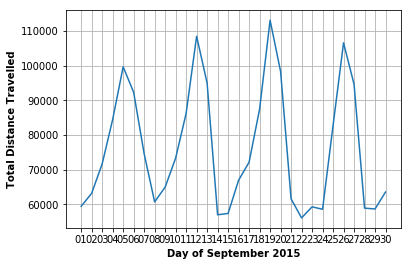

In [209]:
#total distance travelled in days of september (nyny trips)
names = sorted(dateRDD2.keys().collect())
values = dateRDD2.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Day of September 2015', fontweight='bold')
plt.ylabel('Total Distance Travelled', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [51]:
#inference: Total distance travelled is minimal on Mondays, Tuesdays of all weeks in the month of september (nyny)

In [213]:
dateRDD3 = njnj.map(lambda x: (x[1].split(" "),x[10])).map(lambda y: (y[0][0].split("-")[2],float(y[1]))).reduceByKey(lambda a,b: a+b)
print 'total distance travelled in days of september (njnj trips):',dateRDD3.sortByKey().collect()

total distance travelled in days of september (njnj trips): [(u'01', 31394.879999999837), (u'02', 31384.479999999985), (u'03', 33963.95999999999), (u'04', 38198.729999999916), (u'05', 35954.28999999999), (u'06', 32685.11000000003), (u'07', 25629.3099999999), (u'08', 32023.00999999994), (u'09', 34356.12999999994), (u'10', 36786.940000000264), (u'11', 38174.91999999991), (u'12', 41158.31999999986), (u'13', 33036.33999999996), (u'14', 29137.36999999987), (u'15', 30933.10999999999), (u'16', 34025.4200000001), (u'17', 35232.49), (u'18', 38150.24000000017), (u'19', 47076.129999999655), (u'20', 35053.65999999995), (u'21', 32307.77000000007), (u'22', 30698.57999999998), (u'23', 30439.440000000042), (u'24', 31978.680000000182), (u'25', 36896.09000000014), (u'26', 42113.44000000003), (u'27', 34052.70999999987), (u'28', 32618.169999999893), (u'29', 33757.93000000016), (u'30', 34691.11)]


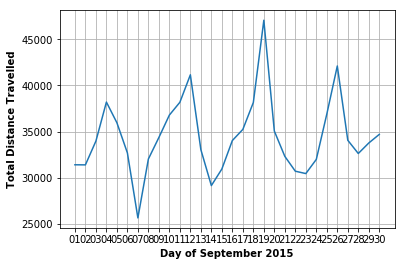

In [214]:
#total distance travelled in days of september (njnj trips)
names = sorted(dateRDD3.keys().collect())
values = dateRDD3.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Day of September 2015', fontweight='bold')
plt.ylabel('Total Distance Travelled', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [215]:
dateRDD4 = njny.map(lambda x: (x[1].split(" "),x[10])).map(lambda y: (y[0][0].split("-")[2],float(y[1]))).reduceByKey(lambda a,b: a+b)
print 'total distance travelled in days of september (njny trips):',dateRDD4.sortByKey().collect()

total distance travelled in days of september (njny trips): [(u'01', 7773.679999999996), (u'02', 8921.919999999991), (u'03', 9586.96000000001), (u'04', 12227.929999999988), (u'05', 12401.509999999987), (u'06', 10181.630000000012), (u'07', 8020.380000000005), (u'08', 8106.539999999998), (u'09', 8376.9), (u'10', 9209.529999999995), (u'11', 11303.039999999995), (u'12', 12202.079999999993), (u'13', 9717.800000000003), (u'14', 7946.270000000006), (u'15', 7256.529999999995), (u'16', 8506.82), (u'17', 9454.210000000017), (u'18', 11371.220000000005), (u'19', 11195.419999999984), (u'20', 10167.140000000005), (u'21', 8200.630000000005), (u'22', 7086.990000000007), (u'23', 7536.890000000005), (u'24', 9256.910000000003), (u'25', 10540.84), (u'26', 11255.609999999997), (u'27', 11065.419999999995), (u'28', 8750.480000000003), (u'29', 8728.369999999984), (u'30', 9163.859999999999)]


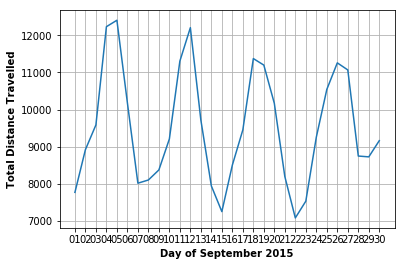

In [216]:
#total distance travelled in days of september (njny trips)
names = sorted(dateRDD4.keys().collect())
values = dateRDD4.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Day of September 2015', fontweight='bold')
plt.ylabel('Total Distance Travelled', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [217]:
dateRDD5 = nynj.map(lambda x: (x[1].split(" "),x[10])).map(lambda y: (y[0][0].split("-")[2],float(y[1]))).reduceByKey(lambda a,b: a+b)
print 'total distance travelled in days of september (nynj trips):',dateRDD5.sortByKey().collect()

total distance travelled in days of september (nynj trips): [(u'01', 23960.50000000007), (u'02', 24795.160000000036), (u'03', 25240.65), (u'04', 28094.01), (u'05', 38468.609999999986), (u'06', 33777.50999999996), (u'07', 26225.73999999996), (u'08', 24031.91999999998), (u'09', 26996.14999999999), (u'10', 25374.75999999992), (u'11', 30048.69999999998), (u'12', 43841.359999999964), (u'13', 38148.36999999995), (u'14', 22200.599999999937), (u'15', 21989.900000000016), (u'16', 25005.559999999998), (u'17', 25614.08999999996), (u'18', 29465.43000000003), (u'19', 42439.039999999964), (u'20', 38945.28000000008), (u'21', 22304.66999999999), (u'22', 20271.81999999999), (u'23', 21015.470000000005), (u'24', 16398.78999999998), (u'25', 22277.91000000001), (u'26', 40597.48000000011), (u'27', 34451.32999999989), (u'28', 20265.110000000015), (u'29', 20796.789999999954), (u'30', 21405.310000000012)]


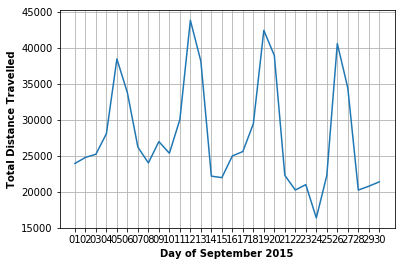

In [218]:
#total distance travelled in days of september (nynj trips)
names = sorted(dateRDD5.keys().collect())
values = dateRDD5.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Day of September 2015', fontweight='bold')
plt.ylabel('Total Distance Travelled', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#inference for task 1.7: Total distance travelled is minimal on Mondays, Tuesdays of all weeks in the month of september (all trips)

In [219]:
# Task 1.8: hour of day vs avg Total Fare amount

In [224]:
revenueavg=rDD.map(timestamp)

In [225]:
avgrev = revenueavg.map(lambda x:(x[20],float(x[16])))

In [226]:
countsKey = sc.broadcast(avgrev.countByKey()) # SAMPLE OUTPUT of countsByKey.value: {u'2013-09-09': 215, u'2013-09-08': 69, ... snip ...}
avgrev = avgrev.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
avgrev = avgrev.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
avgrev1 = avgrev.sortByKey().collect()
print 'Avg Total Fare amount based on hour of the day:', avgrev1

Avg Total Fare amount based on hour of the day: [('00', 15.045700724786641), ('01', 14.505001022818943), ('02', 14.482007476455049), ('03', 14.839847661189195), ('04', 15.723967983651914), ('05', 17.715533532934288), ('06', 17.470734548021902), ('07', 15.874489256278164), ('08', 15.663039090986905), ('09', 15.408813097522666), ('10', 14.897912751445302), ('11', 14.755747565636462), ('12', 14.70618990800407), ('13', 14.60671833951078), ('14', 14.732148235930065), ('15', 14.892425417135478), ('16', 15.425989868236), ('17', 15.007077435185595), ('18', 14.642485063497793), ('19', 14.55494190823746), ('20', 14.278404472103402), ('21', 14.85511780270979), ('22', 15.527859276310721), ('23', 15.471020865968356)]


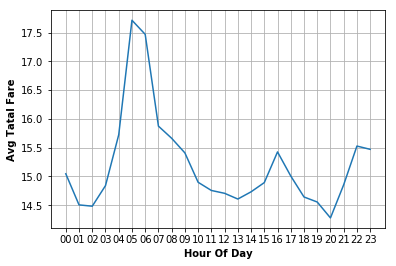

In [227]:
# line graph showing  Avg Total Fare amount based on hour of the day
import numpy as np
names = sorted(avgrev.keys().collect())
values = avgrev.sortByKey().values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hour Of Day', fontweight='bold')
plt.ylabel('Avg Tatal Fare', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#### Input data
sc = ss.sparkContext
GreenTaxi = sc.textFile("/scratch/ISE495/taxi_data")

In [ ]:
from datetime import datetime
from datetime import timedelta

In [ ]:
import operator

In [ ]:
rDD = GreenTaxi.filter(lambda x: x[0:2] != 'Ve').map(lambda x:x.split(","))
nyny1 = rDD.filter(lambda y: (float(y[6])<(1.323942*float(y[5]) + 138.669195)) &(float(y[8])<(1.323942*float(y[7]) + 138.669195))).map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").time()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H"))  ])
njnj1 = rDD.filter(lambda y: (float(y[6])>(1.323942*float(y[5]) + 138.669195)) &(float(y[8])>(1.323942*float(y[7]) + 138.669195))).map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").time()), (datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H")) ])
nynj1 = rDD.filter(lambda y: (float(y[6])<(1.323942*float(y[5]) + 138.669195)) &(float(y[8])>(1.323942*float(y[7]) + 138.669195))).map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").time()), (datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H")) ])
njny1 = rDD.filter(lambda y: (float(y[6])>(1.323942*float(y[5]) + 138.669195)) &(float(y[8])<(1.323942*float(y[7]) + 138.669195))).map(lambda y: [y[0],(datetime.strptime(y[1], "%Y-%m-%d %H:%M:%S")),(datetime.strptime(y[2], "%Y-%m-%d %H:%M:%S")),y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],(datetime.strptime(y[1].split(" ")[0], "%Y-%m-%d").date()),(datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").time()), (datetime.strptime(y[1].split(" ")[1], "%H:%M:%S").strftime("%H")) ])

In [ ]:
nyny = nyny1.map(lambda y: [y[0],y[1],y[2],y[2]-y[1],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],y[21],y[22],y[23]])
njnj = njnj1.map(lambda y: [y[0],y[1],y[2],y[2]-y[1],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],y[21],y[22],y[23]])
nynj = nynj1.map(lambda y: [y[0],y[1],y[2],y[2]-y[1],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],y[21],y[22],y[23]])
njny = njny1.map(lambda y: [y[0],y[1],y[2],y[2]-y[1],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],y[13],y[14],y[15],y[16],y[17],y[18],y[19],y[20],y[21],y[22],y[23]])

In [ ]:
#Avg Tip in every hour of the day NYNY
tripInHr = nyny.map(lambda y: [y[24],float(y[15])])
countsKey = sc.broadcast(tripInHr.countByKey())
tripInHr = tripInHr.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
tripInHr = tripInHr.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
tripInHr1 = tripInHr.sortByKey()
print tripInHr1.collect()

#Plotting above findings
names = sorted(tripInHr1.keys().collect())
values = tripInHr1.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Mean Tip Collected - NYNY', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg Tip in every hours slots of the day NYNJ
nynjTipDur = nynj.map(lambda y: [y[24],float(y[15])])
countsKey = sc.broadcast(nynjTipDur.countByKey())
nynjTipDur = nynjTipDur.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
nynjTipDur = nynjTipDur.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
nynjTipDur1 = nynjTipDur.sortByKey()
print nynjTipDur1.collect()

#Plotting above findings
names = sorted(nynjTipDur1.keys().collect())
values = nynjTipDur1.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Mean Tip Collected NYNJ', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg Tip in every hours slots of the day NYNJ
nynjTipDur = nynj.map(lambda y: [y[24],float(y[15])])
countsKey = sc.broadcast(nynjTipDur.countByKey())
nynjTipDur = nynjTipDur.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
nynjTipDur = nynjTipDur.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
nynjTipDur1 = nynjTipDur.sortByKey()
print nynjTipDur1.collect()

#Plotting above findings
names = sorted(nynjTipDur1.keys().collect())
values = nynjTipDur1.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Mean Tip Collected NYNJ', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg Tip in every hours slots of the day NJNJ
njnjTipDur = njnj.map(lambda y: [y[24],float(y[15])])
countsKey = sc.broadcast(njnjTipDur.countByKey())
njnjTipDur = njnjTipDur.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
njnjTipDur = njnjTipDur.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
njnjTipDur1 = njnjTipDur.sortByKey()
print njnjTipDur1.collect()

#Plotting above findings
names = sorted(njnjTipDur1.keys().collect())
values = njnjTipDur1.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Mean Tip Collected NJNJ', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg Tip in every hours slots of the day NJNY
njnyTipDur = njny.map(lambda y: [y[24],float(y[15])])
countsKey = sc.broadcast(njnyTipDur.countByKey())
njnyTipDur = njnyTipDur.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
njnyTipDur = njnyTipDur.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
njnyTipDur1 = njnyTipDur.sortByKey()
print njnyTipDur1.collect()

#Plotting above findings
names = sorted(njnyTipDur1.keys().collect())
values = njnyTipDur1.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Mean Tip Collected NJNY', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg total amount earned in every hour of the day NYNY

nynyTot= nyny.map(lambda y: [y[24],float(y[19])])
countsKey = sc.broadcast(nynyTot.countByKey())
nynyTot = nynyTot.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
nynyTot = nynyTot.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
nynyTot1 = nynyTot.sortByKey()
print nynyTot1.collect()

#Plotting above findings
names = sorted(nynyTot1.keys().collect())
values = nynyTot1.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Average Revenue - NYNY', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg total amount earned in every hour of the day NYNJ

nynjTot2= nynj.map(lambda y: [y[24],float(y[19])])
countsKey = sc.broadcast(nynjTot2.countByKey())
nynjTot2 = nynjTot2.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
nynjTot2 = nynjTot2.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
nynjTot21 = nynjTot2.sortByKey()
print nynjTot21.collect()

#Plotting above findings
names = sorted(nynjTot21.keys().collect())
values = nynjTot21.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Average Revenue - NYNJ', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg total amount earned in every hour of the day NJNJ

njnjTot3= njnj.map(lambda y: [y[24],float(y[19])])
countsKey = sc.broadcast(njnjTot3.countByKey())
njnjTot3 = njnjTot3.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
njnjTot3 = njnjTot3.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
njnjTot31 = njnjTot3.sortByKey()
print njnjTot31.collect()

#Plotting above findings
names = sorted(njnjTot31.keys().collect())
values = njnjTot31.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Average Revenue - NJNJ', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg total amount earned in every hour of the day NJNY

njnyTot= njny.map(lambda y: [y[24],float(y[19])])
countsKey = sc.broadcast(njnyTot.countByKey())
njnyTot = njnyTot.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
njnyTot = njnyTot.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
njnyTot1 = njnyTot.sortByKey().collect()
print njnyTot1

#Plotting above findings
names = sorted(njnyTot.keys().collect())
values = njnyTot.values().collect()
r1 = np.arange(len(names))
plt.grid(True)
plt.plot(r1, values)
plt.xlabel('Hours', fontweight='bold')
plt.ylabel('Average Revenue - NJNY', fontweight='bold')
plt.xticks([r for r in range(len(names))], names)
plt.show()

In [ ]:
#Avg  tip earned for each day of the day NJNY
nynyTipDAY= nyny.map(lambda y: [y[22],float(y[15])])
countsKey = sc.broadcast(nynyTipDAY.countByKey())
nynyTipDAY = nynyTipDAY.reduceByKey(operator.add) # Calculate the numerators (i.e. the SUMs).
nynyTipDAY = nynyTipDAY.map(lambda x: (x[0], x[1]/countsKey.value[x[0]])) # Divide each SUM by it's denominator (i.e. COUNT)
nynyTipDAY1 = nynyTipDAY.sortByKey()
print nynyTipDAY1.collect()

comp2 = nynyTipDAY1.keys().collect()
comp2Val = nynyTipDAY1.values().collect()

r1 = np.arange(len(comp2))

plt.bar(r1+1, comp2Val, color='#7f6d5f', width=0.5, edgecolor='white', label='comp1')
plt.xlabel('DAYS', fontweight='bold')
plt.ylabel('Average Tip - NYNY', fontweight='bold')


plt.show()

In [ ]:
sc.stop()

In [7]:
ss.stop()